# Reformatting data

The data are stored in GeoTiff format and each contain four bands of data: red, green, blue, and near infrared.


The work below loads this data along with labels and saves it to a TFRecord file with "image" and "label" features.

The labels are stored as an int8 array. Each value corresponds to a tag string, where 1 means that the tag is associated with the example image

In [10]:
import  sys
import os
import subprocess

import numpy as np
import pandas as pd
import seaborn as sns
import rasterio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import rasterio
import tensorflow as tf

%matplotlib inline

/workspace/anaconda/anaconda4/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [11]:
cd /workspace/planet-understanding-the-amazon-from-space/

/workspace/planet-understanding-the-amazon-from-space


In [12]:
label_csv = pd.read_csv('train_v2.csv')

In [13]:
label_csv.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [14]:
labels = set()
for l in label_csv['tags']:
    for ll in l.split(' '):
        labels.add(ll)

In [15]:
labelslist = list(labels)
labelslist.sort()

In [16]:
labelslist

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

In [17]:
label_frequency = {}
for l in labels: 
    label_frequency[l] = 0
    

In [18]:
for l in label_csv['tags']:
    for ll in l.split(' '):
        label_frequency[ll] += 1

In [19]:
label_indices = {}
for i, l in enumerate(labelslist):
    label_indices[l] = i

In [20]:
label_mat = np.zeros((len(label_csv), len(labels)), bool)
for i, l in enumerate(label_csv['tags']):
    for ll in l.split(' '):
        label_mat[i, label_indices[ll]] = True

In [21]:
cd train-tif-v2/

/workspace/planet-understanding-the-amazon-from-space/train-tif-v2


/workspace/anaconda/anaconda4/lib/python3.6/site-packages/rasterio/__init__.py:193: UserWarning: Dataset has no geotransform set.  Default transform will be applied (Affine.identity())
  s.start()


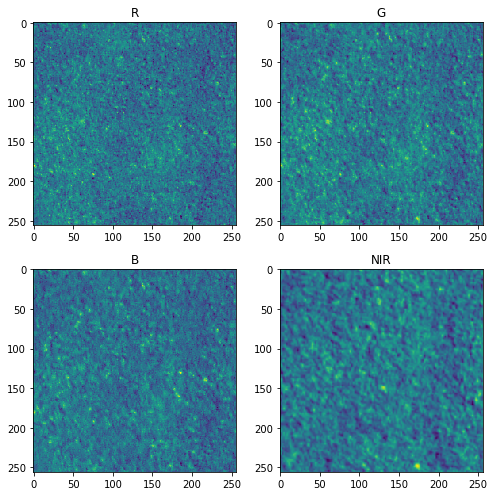

In [22]:
with rasterio.open('train_0.tif') as r:
    ar = r.read()
    
ar = ar.transpose(1,2,0)  # h, w, depth
h, w, d = ar.shape
channels = 'R', 'G', 'B', 'NIR'
f, ps = plt.subplots(2,2, figsize = (7,7))

plots = []
for p in ps: plots.extend(p)
for i in range(d):
    plots[i].imshow(ar[:,:,i])
    plots[i].set_title(channels[i])
plt.tight_layout()

In [25]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

writer = tf.python_io.TFRecordWriter('../train.tf')
writer_tst = tf.python_io.TFRecordWriter('../test_sub.tf')

from tqdm import tqdm
import glob

# write 1% of the data to a test file instead of the regular file. 
leaveout = np.random.randint(0, len(glob.glob('*.tif')), 400)
leaveout.sort()



for row in tqdm(label_csv.iterrows(), total = len(label_csv)):
    
    rowdata = row[1]
    tags = rowdata['tags']
    imgname = rowdata['image_name']
    label_row = np.zeros(len(labels), 'int8')
    for ll in tags.split(' '):
        label_row[label_indices[ll]] = True
    with rasterio.open(imgname + '.tif') as f:
        imagearray = f.read()
    imagearrayT = imagearray.transpose(1,2,0)  # h, w, depth
    h, w, d = imagearrayT.shape
    
    feature = {'label': _bytes_feature(tf.compat.as_bytes(label_row.tostring())),
               'image': _bytes_feature(tf.compat.as_bytes(imagearrayT.tostring())),
                'h':_int64_feature(h), 'w':_int64_feature(w), 'd': _int64_feature(d)}

    # Create an example protocol buffer
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    
    if row[0] not in leaveout:
        w = writer
    else:
        w = writer_tst
    
    w.write(example.SerializeToString())
writer.close()
writer_tst.close()
    
    

  0%|          | 0/40479 [00:00<?, ?it/s]/workspace/anaconda/anaconda4/lib/python3.6/site-packages/rasterio/__init__.py:193: UserWarning: Dataset has no geotransform set.  Default transform will be applied (Affine.identity())
  s.start()
100%|██████████| 40479/40479 [02:51<00:00, 236.65it/s]


In [24]:
row

(0, image_name         train_0
 tags          haze primary
 Name: 0, dtype: object)

In [51]:
data_path = '../train.tf'

def read_and_decode(filename_queue):
    feature = {'image': tf.FixedLenFeature([], tf.string),
               'label': tf.FixedLenFeature([], tf.string),
               'h': tf.FixedLenFeature([], tf.int64),
               'w': tf.FixedLenFeature([], tf.int64),
               'd': tf.FixedLenFeature([], tf.int64),
               }
    # Define a reader and read the next record
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    # Decode the record read by the reader
    features = tf.parse_single_example(serialized_example, features=feature)
    # Convert the image data from string back to the numbers
    image = tf.decode_raw(features['image'], tf.uint16)
    label = tf.decode_raw(features['label'], tf.int8)

    # Cast label data into int32

    h = tf.cast(features['h'], tf.int32)
    w = tf.cast(features['w'], tf.int32)
    d = tf.cast(features['d'], tf.int32)
    # Reshape image data into the original shape
    image = tf.reshape(image, [256,256,4])
    label = tf.reshape(label, [17])
    
    images, labels = tf.train.shuffle_batch( [image, label],
                                                 batch_size=2,
                                                 capacity=30,
                                                 num_threads=2,
                                                 min_after_dequeue=10)
    
    # Any preprocessing here ...
    return images, labels
    # Creates batches by randomly shuffling tensors
    

In [52]:
filename_queue = tf.train.string_input_producer([data_path], num_epochs=1)

In [53]:
image, annotation = read_and_decode(filename_queue)

(256, 256, 4)
[[1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1]]
current batch


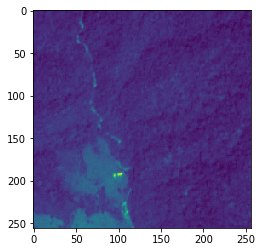

(256, 256, 4)
[[0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]]
current batch


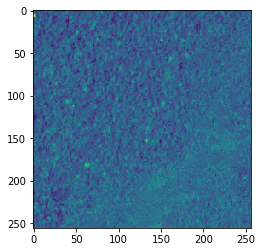

In [58]:
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session()  as sess:
    
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Let's read off 3 batches just for example
    for i in range(2):
    
        img, anno = sess.run([image, annotation])
        print(img[0, :, :, :].shape)
        print(anno)
        
        print('current batch')
        
        # We selected the batch size of two
        # So we should get two image pairs in each batch
        # Let's make sure it is random

        plt.imshow(img[0, :, :, 0])
        plt.show()
        
    
    coord.request_stop()
    coord.join(threads)


In [1]:
import glob

In [5]:
ls

test-jpg/             test-tif-v2/              train-jpg/  train-tif-v2/
test-jpg-additional/  test_v2_file_mapping.csv  train.tf    train_v2.csv


In [9]:
len(glob.glob('train-tif-v2/*.tif'))

40479